# Assignment 8: Neural Networks

Only use the already imported library `numpy` and the Python standard library. For the evaluation you may also use scikit-learn (`sklearn`) and `matplotlib`. Make sure that the dataset `airfoil_self_noise.csv` is in the same directory as the notebook.

List your team members (name and immatriculation number) and indicate whether you are a B.Sc. Data Science or other group in the following cell:

- Yang Zheng  (3434770)
- Yuchan Bian (3496226)
- Zhiming Ma  (3495421)

Other group, not B.Sc. Data Science

In [27]:
import numpy as np

def load_dataset(path):
    from sklearn.model_selection import train_test_split
    
    data = np.genfromtxt(path)
    X, y = data[:, :5], data[:, 5]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

    return X_train, X_test, y_train, y_test
    

X_train, X_test, y_train, y_test = load_dataset('airfoil_self_noise.csv')

## Task 3: Feedforward Neural Network: Programming

In this task, you will implement a feedforward neural network for regression. The hyperparameters of the model are:
- `input_dim`: The dimension of the input vector.
- `output_dim`: The dimension of the output vector.
- `width`: The dimension of each hidden layer.
- `depth`: The number of hidden layers. For B.Sc. Data Science students, this parameter is constant with a value of 1.
- `learning_rate`: The learning rate for gradient descent.
- `epochs`: The number of epochs/iterations performed during training.

B.Sc. Data Science only have to implement for a single hidden layer, i.e. `depth = 1`. All other students have to implement the network for any `depth >= 1`.

The activation function for each hidden layer is ReLU (g(x) = max(0, x)). The output layer uses the identity as activation, since our objective is regression.

You have to implement the `FeedforwardNeuralNetworkRegressor`.

The `__init__` method initializes the network.
Initialize each weight and bias randomly with a standard Gaussian distribution using the numpy function `numpy.random.normal` with default parameters.

The `fit` method trains the network.
Use backpropagation with gradient descent similar to Task 2.
Use the whole training data set for each training epoch.
Use the mean squared error as loss function.

The `predict` method computes the forward-pass of the network.

Evaluate your classifier on the test data with the mean squared error and compare your results to your linear regression model from assignment 3. Try out different hyper-parameters and compare the results. You may want to normalize your input and output data for better performance.

In [28]:
class FeedforwardNeuralNetworkClassifier(object):
    # four methods: _init_, fit, predict, foreward
    def __init__(self, input_dim, output_dim, width, depth, learning_rate, epochs):
        # Add your code, such as initialization of weights here.
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.width = width
        self.depth = depth
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        self.layer_params = []
        
        # normal distributed parameters
        for dep in range(depth+1):
            layer = []
            if dep == 0:
                weight = np.random.normal(0,1,size = (width[dep],input_dim))
                bias = np.random.normal(0,1,size = (width[dep],1))
            elif dep == depth:
                weight = np.random.normal(0,1,size = (output_dim, width[dep-1]))
                bias = np.random.normal(0,1,size = (output_dim,1))
            else:
                weight = np.random.normal(0,1,size = (width[dep], width[dep-1]))
                bias = np.random.normal(0,1,size = (width[dep],1))
                
            layer.append(weight)
            layer.append(bias)
            self.layer_params.append(layer)
            
    def fit(self, X, y):
        
        losses = np.zeros(self.epochs)
        loss_accum = 0
        data_length = X.shape[0]
        
        #normalization
        mu = np.mean(X,axis=0)
        dev = np.sqrt(np.var(X,axis=0))
        
        for ep in range(self.epochs):
            print('epoch:',ep)
            
            #foreward       
            X_0 = (X.copy() - mu* np.ones((X.shape[0],X.shape[1])))/dev
            
            X_0 = np.transpose(X_0)
            
            y_pred, tempXs, loss = self.foreward(X_0[:,0], y[0])
            
            loss_accum = loss_accum + loss
            #losses.append(loss)

            # Slide Page 63
            for num in range(data_length):
                #dL_dy_pred_i
                step = 2 * (y_pred - y[num])/data_length
            
                #back propagation
                for dep in reversed(range(self.depth+1)):
                    phi = tempXs[dep].copy()
            
                    #derivative of ReLU
                    phi[phi>0] = 1
                    phi[phi<=0] = 0

                    step = step * phi
                    
                    #step of b
                    step_b = step
                    
                    #step of W
                    if dep == 0:
                        step_w = np.dot(step, X_0[:,num].reshape((1,-1)))
                    else:
                        step_w = np.dot(step, tempXs[dep-1].T)
                    
                    step = np.dot(self.layer_params[dep][0].T,step)
                    
                    self.layer_params[dep][0] = self.layer_params[dep][0] - self.learning_rate * step_w
                    self.layer_params[dep][1] = self.layer_params[dep][1] - self.learning_rate * step_b
                
                if num != data_length-1:
                    y_pred, tempXs, loss = self.foreward(X_0[:,num+1], y[num+1])
                    loss_accum = loss_accum + loss
                    
            losses[ep] = loss_accum/data_length
            loss_accum = 0
                    
        return losses
            
    def predict(self, X):
        mu = np.mean(X,axis=0)
        dev = np.sqrt(np.var(X,axis=0))
        
        # normalize
        X_nor = (X.copy() - mu* np.ones((X.shape[0],X.shape[1])))/dev
        
        y_pred = np.zeros((X_nor.shape[0],1))
        for num in range(X.shape[0]):
            y, tempXs, loss = self.foreward(X_nor[num,:], 0)
            y_pred[num] = y
        return y_pred[:,0]
    
    def foreward(self, X, y):
        
        data_length = 1
        tempXs = []
        tempX = X.copy()
        tempX = tempX.reshape((-1,1))
        
        for dep in range(self.depth+1):
            activ =  np.dot(self.layer_params[dep][0],tempX) + data_length * self.layer_params[dep][1]
            
            #ReLU activation function
            if dep == self.depth:
                tempX = np.maximum(np.zeros((self.output_dim,data_length)),activ)
            else:
                tempX = np.maximum(np.zeros((self.width[dep],data_length)),activ)
                
            tempXs.append(tempX)
            
        if y != 0:
            loss = (tempX - y)**2
        else:
            loss = 0
        
        return tempX, tempXs, loss

In [29]:
# Implement your training and evaluation here.
epoch = 10
rate = 0.01

imput_dim = X_train.shape[1]

#arbitary width, can be adjusted as wished
width = np.array([5,6,4])

depth = len(width)
myFeedforewardNNC = FeedforwardNeuralNetworkClassifier(imput_dim, 1, width, depth, rate, epoch)
losses = myFeedforewardNNC.fit(X_train,y_train)

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9


[1844.58096793   74.17630029   42.06207885   30.98633916   26.36694568
   23.95689753   22.71750565   21.99960002   21.52725158   21.17377058]


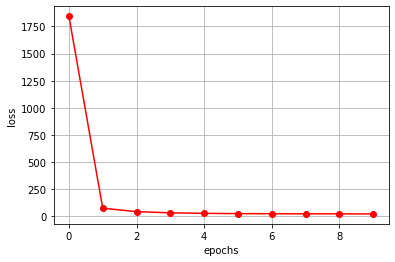

In [30]:
print(losses)
x1 = np.arange(epoch)

import matplotlib.pyplot as plt
line = plt.plot(x1,losses,'ro-')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

In [31]:
y_pred = myFeedforewardNNC.predict(X_test)
MSE = np.sum((y_pred-y_test)**2)/len(y_pred)
print('Mean square error of test data is', MSE)

Mean square error of test data is 22.16711425422826
